## Description

In this notebook, we compare the masserstein proportions with the monoisotopic peak intensities.

## Data & modules

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from time import time
import pandas as pd
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra

In [3]:
import numpy.random as rd

In [4]:
analyzed_mass_range = (600, 1000)

In [5]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [6]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [7]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [8]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

In [9]:
lipid_formulas = {n : [] for n in image_names}
for i, n in enumerate(image_names):
    with open(n + '_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            lipid_formulas[n].append(l[0])
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

FileNotFoundError: [Errno 2] No such file or directory: 'cerebellum_annotation_results.tsv'

In [ ]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()
        assert analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]

In [ ]:
lipid_masses = {n: [s.confs[0][0] for s in lipid_spectra[n]] for n in image_names}

Load the quantification results from Notebook 5:

In [10]:
masserstein_estimation = {n : np.load(n+'_regression_images.dmp', allow_pickle=True) for n in image_names}
[masserstein_estimation[n].shape for n in image_names]

[(21, 81, 207), (134, 260, 180)]

In [11]:
single_peak_intensities = {n : np.load(n+'_single_peak_images.dmp', allow_pickle=True) for n in image_names}
[single_peak_intensities[n].shape for n in image_names]

[(21, 81, 207), (134, 260, 180)]

In [ ]:
lipid_id = 34

plt.figure()
plt.subplot(221)
plt.title('Example lipid, peak, cerebellum')
plt.imshow(single_peak_intensities['cerebellum'][...,lipid_id])
plt.subplot(222)
plt.title('Example lipid, masserstein, cerebellum')
plt.imshow(masserstein_estimation['cerebellum'][...,lipid_id])
plt.subplot(223)
plt.title('Example lipid, peak, bladder')
plt.imshow(single_peak_intensities['bladder'][...,lipid_id])
plt.subplot(224)
plt.title('Example lipid, masserstein, bladder')
plt.imshow(masserstein_estimation['bladder'][...,lipid_id])
plt.tight_layout()
plt.show()

In [ ]:
nb_of_nonzero_pixels = {n: np.sum(masserstein_estimation[n]>0, axis=(0,1)) for n in image_names}
is_in_enough_pixels = {n: nb_of_nonzero_pixels[n] >= 400 for n in image_names}

## Comparing the distributions of total intensity

In [19]:
total_lipid_signals_masserstein = {n: masserstein_estimation[n].sum(axis=(0,1)) for n in image_names}
total_lipid_signals_peak = {n: single_peak_intensities[n].sum(axis=(0,1))for n in image_names}

<IPython.core.display.Javascript object>


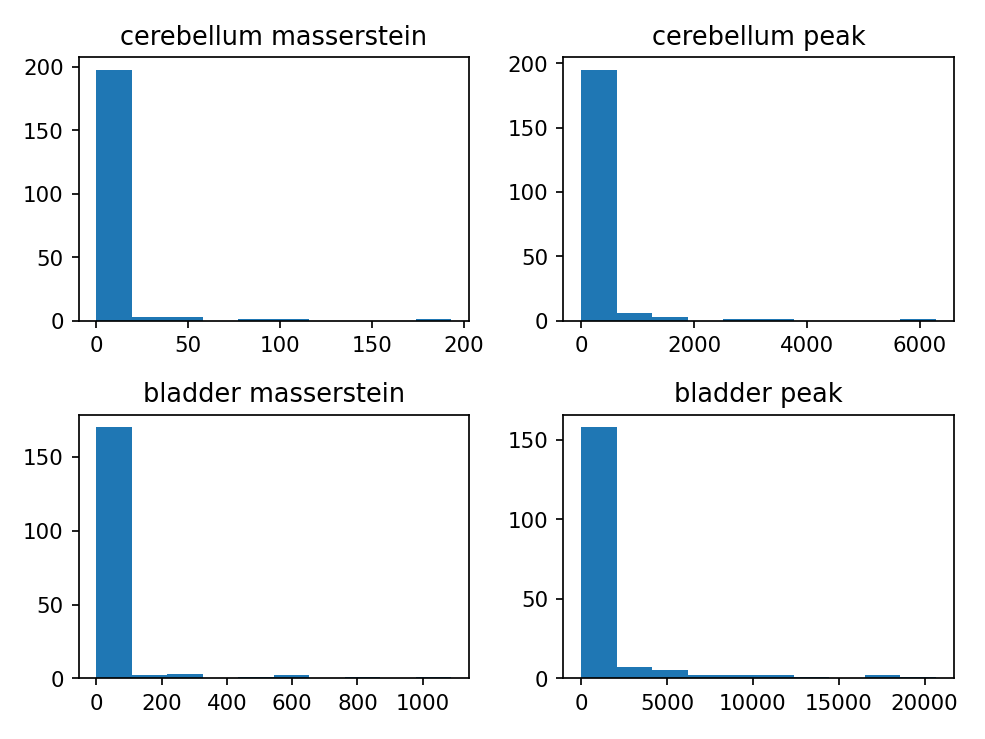

In [18]:
plt.figure()
for i,n in enumerate(image_names):
    plt.subplot(221+2*i)
    plt.title(n + ' masserstein')
    plt.hist(total_lipid_signals_masserstein[n])
    plt.subplot(222+2*i)
    plt.title(n + ' peak')
    plt.hist(total_lipid_signals_peak[n])
plt.tight_layout()

In [20]:
total_pixel_signals_masserstein = {n: masserstein_estimation[n].sum(axis=2) for n in image_names}
total_pixel_signals_peak = {n: single_peak_intensities[n].sum(axis=2) for n in image_names}

<IPython.core.display.Javascript object>


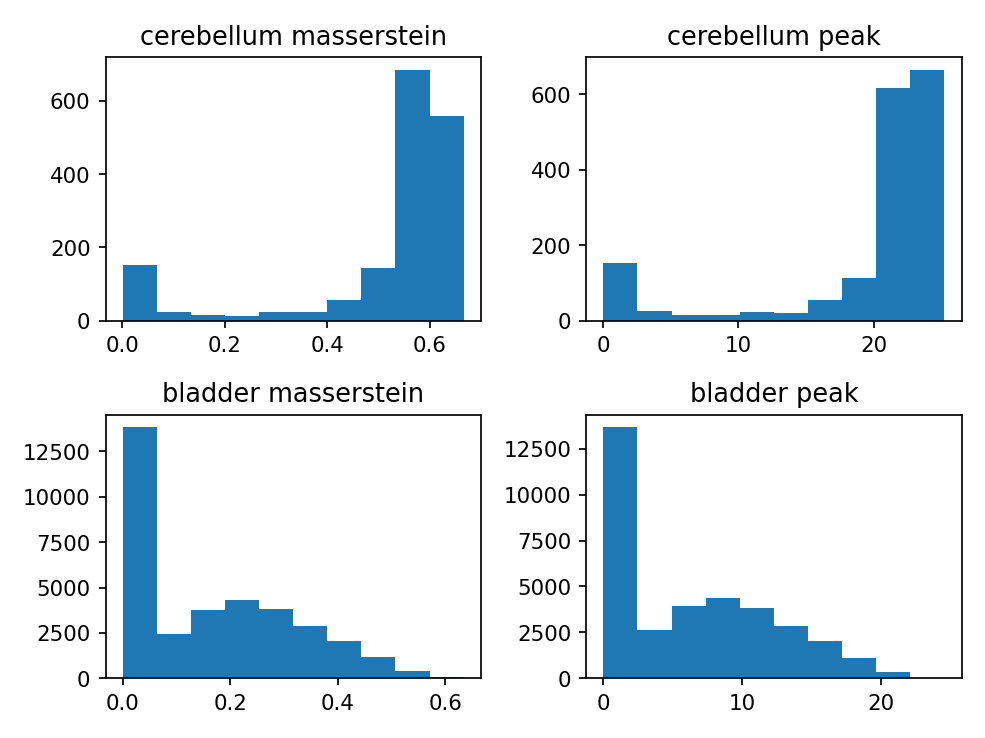

In [23]:
plt.figure()
for i,n in enumerate(image_names):
    plt.subplot(221+2*i)
    plt.title(n + ' masserstein')
    plt.hist(total_pixel_signals_masserstein[n].flatten())
    plt.subplot(222+2*i)
    plt.title(n + ' peak')
    plt.hist(total_pixel_signals_peak[n].flatten())
plt.tight_layout()

## Comparing the estimated spatial distributions

In [16]:
for n in image_names:
    print(n)
    print(sorted([s.confs[0][0] for s in lipid_spectra[n]]))

cerebellum
[700.28641961624, 700.359190634, 701.30682070885, 701.37959172661, 702.3748406985401, 703.28608526451, 703.39524179115, 704.39049076308, 705.44727736457, 711.43671267983, 712.5047326695201, 713.45236274437, 713.4887482532499, 714.41122620742, 715.46801280891, 716.42687627196, 716.46326178084, 722.48908260498, 725.4887482532499, 725.49998164145, 726.3748406985401, 727.46801280891, 727.51563170599, 728.42687627196, 732.4217908921601, 737.45236274437, 739.46801280891, 741.4836628734499, 741.49489626165, 741.53128177053, 742.40614082762, 742.4425263365, 742.47891184538, 743.46292742911, 743.49931293799, 743.5469318350699, 744.45817640104, 744.49456190992, 745.4785774936499, 753.4836628734499, 753.53128177053, 754.40614082762, 755.46292742911, 755.5469318350699, 757.55134851141, 758.5102119744599, 760.45309102124, 761.45236274437, 762.48399722518, 763.46801280891, 764.5360327986, 765.4836628734499, 766.5516828631401, 767.49931293799, 767.5469318350699, 768.47343254044, 768.567332

In [17]:
signal_correlations = {n: np.zeros(len(lipid_spectra[n])) for n in image_names}
for n in image_names:
    for i in range(len(lipid_spectra[n])):
        peak = single_peak_intensities[n][...,i]
        prop = masserstein_estimation[n][...,i]
        peak = peak - np.mean(peak)
        peak = peak / np.std(peak)
        prop = prop - np.mean(prop)
        prop = prop / np.std(prop)
        signal_correlations[n][i] = np.mean(peak*prop)

<IPython.core.display.Javascript object>


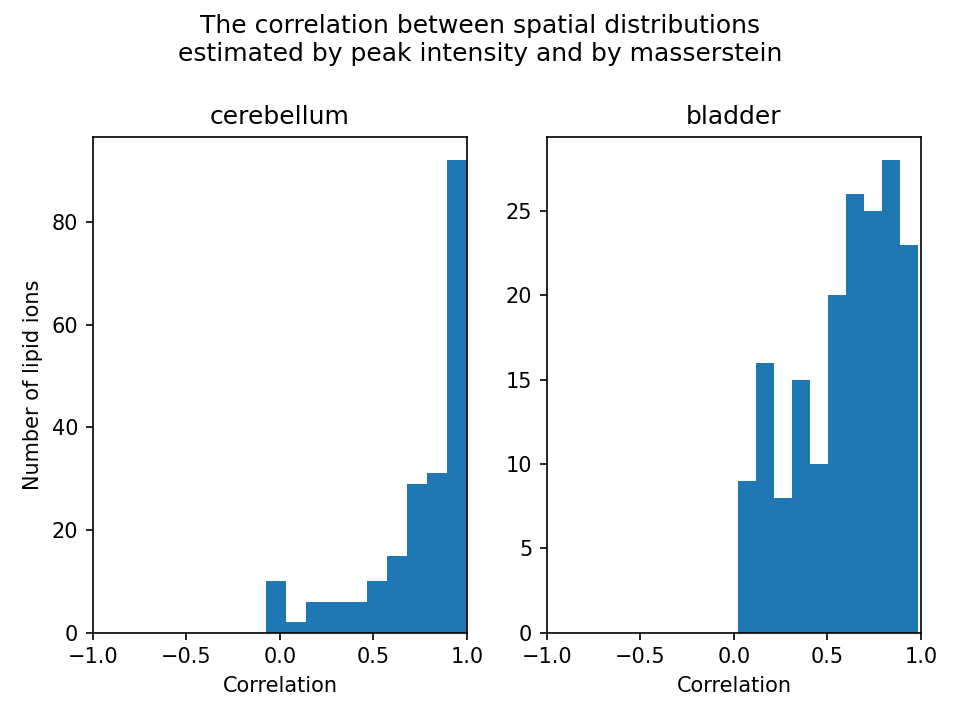

In [18]:
plt.figure()
plt.suptitle('The correlation between spatial distributions\nestimated by peak intensity and by masserstein')
plt.subplot(121)
plt.title(image_names[0])
plt.hist(signal_correlations[image_names[0]])
plt.xlabel('Correlation')
plt.ylabel('Number of lipid ions')
plt.xlim(-1, 1)
plt.subplot(122)
plt.title(image_names[1])
plt.hist(signal_correlations[image_names[1]])
plt.xlabel('Correlation')
plt.xlim(-1, 1)
plt.tight_layout()
plt.show() 

Summarize the correlations

In [19]:
print('Number of highly correlated lipids, rho>=0.8:')
for n in image_names:
    print(n, np.sum(signal_correlations[n] >= 0.8))
    
print('Number of moderately correlated lipids, 0.6<=rho<0.8:')
for n in image_names:
    print(n, np.sum((signal_correlations[n] >= 0.6)*(signal_correlations[n] < 0.8)))

print('Number of highly distorted lipids, rho<0.6:')
for n in image_names:
    print(n, np.sum(signal_correlations[n] < 0.6))


Number of highly correlated lipids, rho>=0.8:
cerebellum 115
bladder 46
Number of moderately correlated lipids, 0.6<=rho<0.8:
cerebellum 48
bladder 56
Number of highly distorted lipids, rho<0.6:
cerebellum 44
bladder 78


Check the dependence between the correlation and the number of pixels in which a lipid was detected:

<IPython.core.display.Javascript object>


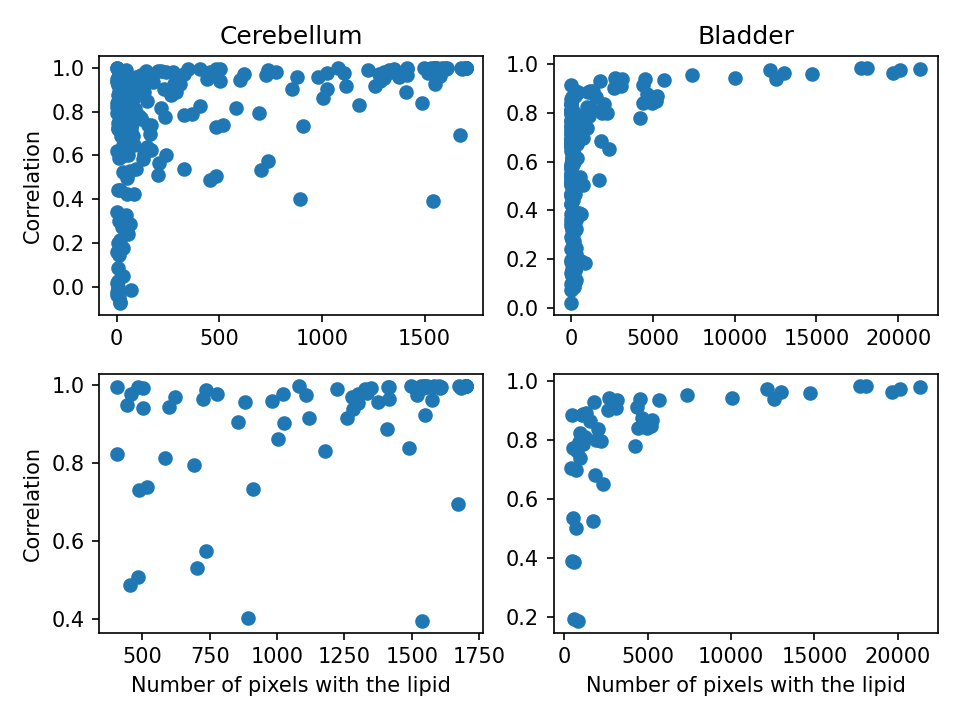

In [20]:
plt.figure()
plt.subplot(221)
plt.title('Cerebellum')
plt.ylabel('Correlation')
plt.scatter(nb_of_nonzero_pixels['cerebellum'], signal_correlations['cerebellum'])
plt.subplot(222)
plt.title('Bladder')
plt.scatter(nb_of_nonzero_pixels['bladder'], signal_correlations['bladder'])
plt.subplot(223)
plt.ylabel('Correlation')
plt.scatter(nb_of_nonzero_pixels['cerebellum'][is_in_enough_pixels['cerebellum']], 
            signal_correlations['cerebellum'][is_in_enough_pixels['cerebellum']])
plt.xlabel('Number of pixels with the lipid')
plt.subplot(224)
plt.scatter(nb_of_nonzero_pixels['bladder'][is_in_enough_pixels['bladder']], 
            signal_correlations['bladder'][is_in_enough_pixels['bladder']])
plt.xlabel('Number of pixels with the lipid')
plt.tight_layout()

Examples of moderately correlated lipids

<IPython.core.display.Javascript object>


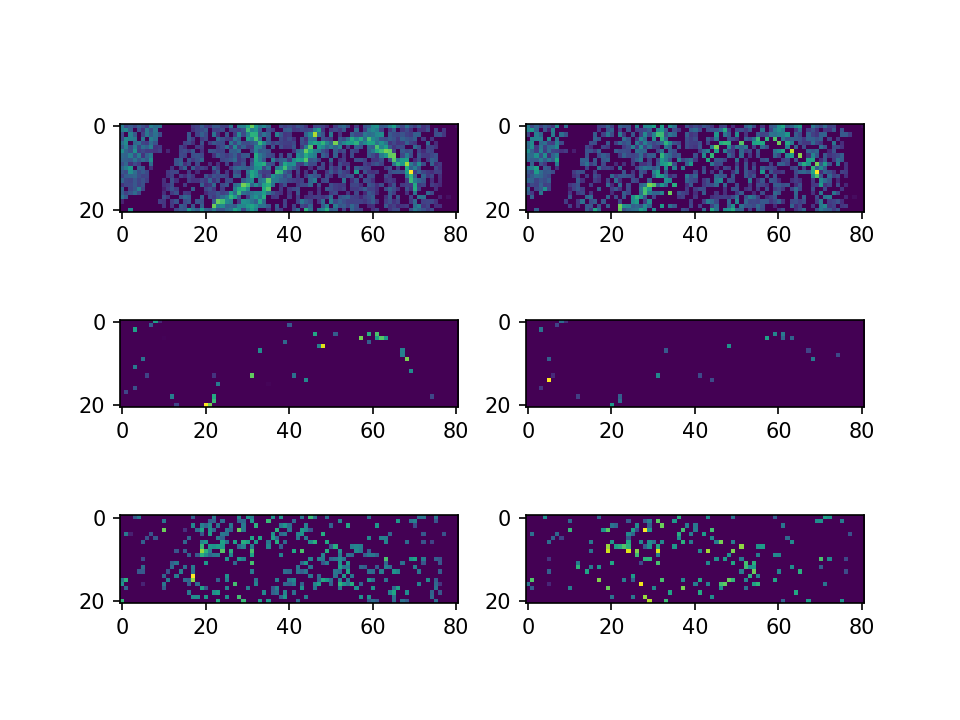

In [21]:
plt.figure()
for i, lid in enumerate(np.where((signal_correlations['cerebellum'] >= 0.6)*(signal_correlations['cerebellum'] < 0.9))[0][:3]):
    plt.subplot(321+2*i)
    plt.imshow(single_peak_intensities['cerebellum'][...,lid])
    plt.subplot(322+2*i)
    plt.imshow(masserstein_estimation['cerebellum'][...,lid])

<IPython.core.display.Javascript object>


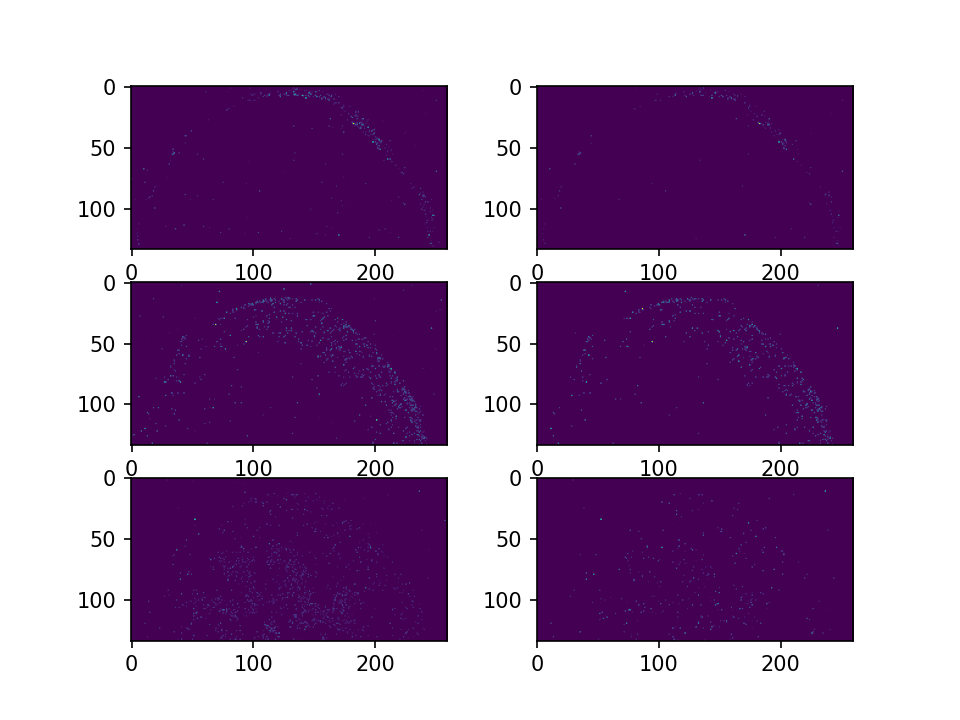

In [22]:
plt.figure()
for i, lid in enumerate(np.where((signal_correlations['bladder'] >= 0.6)*(signal_correlations['bladder'] < 0.9))[0][:3]):
    plt.subplot(321+2*i)
    plt.imshow(single_peak_intensities['bladder'][...,lid])
    plt.subplot(322+2*i)
    plt.imshow(masserstein_estimation['bladder'][...,lid])

Showing three lowest-correlation lipids per image:

<IPython.core.display.Javascript object>


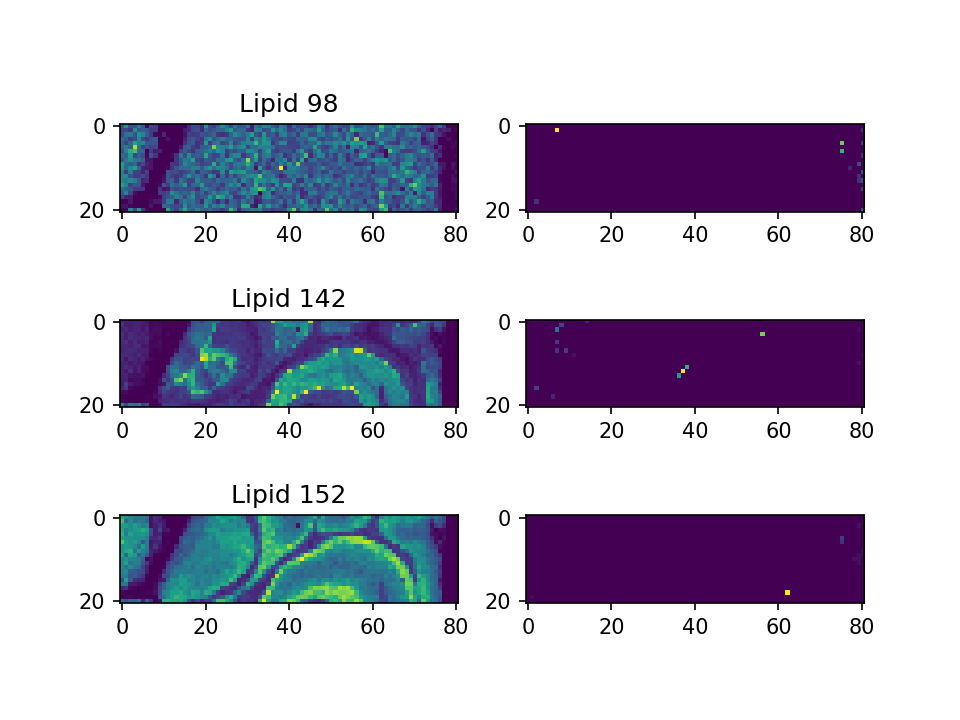

In [23]:
plt.figure()
for i, lid in enumerate(np.argsort(signal_correlations['cerebellum'])[:3]):
    plt.subplot(321+2*i)
    plt.title('Lipid %i' % lid)
    plt.imshow(single_peak_intensities['cerebellum'][...,lid])
    plt.subplot(322+2*i)
    plt.imshow(masserstein_estimation['cerebellum'][...,lid])

<IPython.core.display.Javascript object>


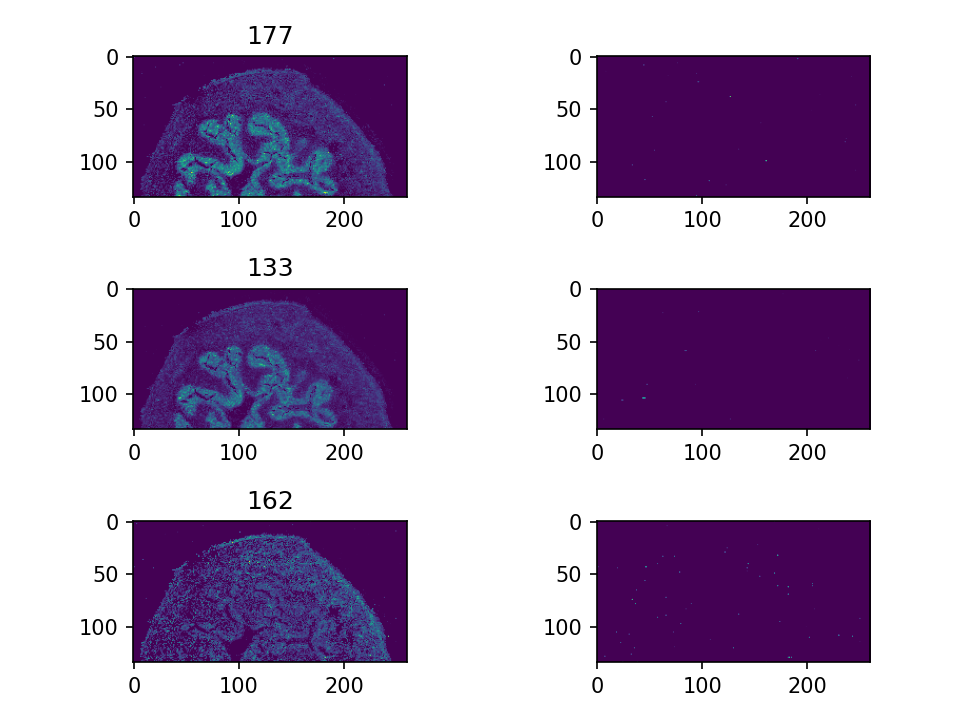

In [24]:
plt.figure()
for i, lid in enumerate(np.argsort(signal_correlations['bladder'])[:3]):
    plt.subplot(321+2*i)
    plt.title(lid)
    plt.imshow(single_peak_intensities['bladder'][...,lid])
    plt.subplot(322+2*i)
    plt.imshow(masserstein_estimation['bladder'][...,lid])
plt.tight_layout()

A lot of the low-correlated lipids are "micro-biomarkers". 
While these may be interesting and useful lipids, they likely require a different computational approach and a specialized analysis to make sure they're not false positives. 
Especially when they're subject to overlapping isotopic envelopes.   
Let's check some "micro-biomarkers":

In [113]:
test_image = 'cerebellum'
test_lid = 142
test_sp = lipid_spectra[test_image][test_lid]
masserstein_mask = masserstein_estimation[test_image][...,test_lid] > 0.0002
peak_mask = single_peak_intensities['cerebellum'][...,test_lid] > 0.5
mass_axis = np.linspace(test_sp.confs[0][0] - 5, test_sp.confs[0][0]+10, num=5001)
lc_sp, hc_sp = segment_average_spectra(profile_images[test_image], masserstein_mask, mass_axis)
peak_lc_sp, peak_hc_sp = segment_average_spectra(profile_images[test_image], peak_mask, mass_axis)
# lc_sp /= np.sum(lc_sp) # np.sum(~masserstein_mask)
# hc_sp /= np.sum(hc_sp) # np.sum(masserstein_mask)
test_sp = test_sp*(np.interp(test_sp.confs[0][0], mass_axis, hc_sp)/test_sp.confs[0][1])

In [110]:
competing_lids = [i for i,s in enumerate(lipid_spectra[test_image]) if abs(s.confs[0][0] - test_sp.confs[0][0])<0.01]
competing_lids

[24, 142]

In [111]:
competing_sp = lipid_spectra[test_image][24]
# below we take the mass of test_sp on purpose
competing_sp = competing_sp*(np.interp(test_sp.confs[0][0], mass_axis, hc_sp)/competing_sp.confs[0][1])

<IPython.core.display.Javascript object>


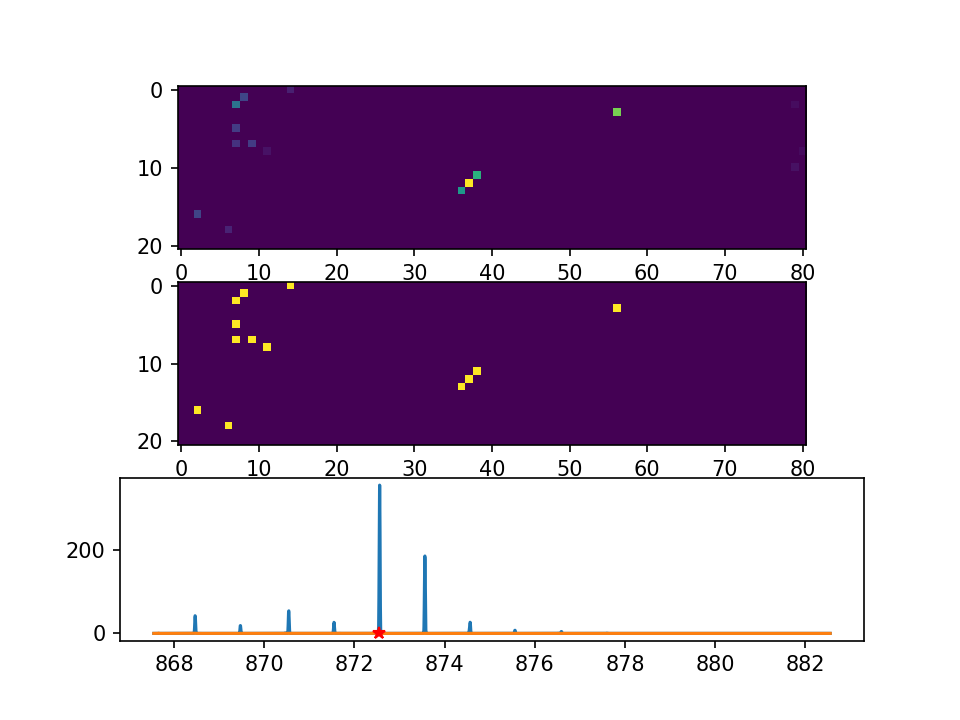

In [114]:
plt.figure()
plt.subplot(311)
plt.imshow(masserstein_estimation[test_image][...,test_lid])
plt.subplot(312)
plt.imshow(masserstein_mask)
plt.subplot(313)
plt.plot(mass_axis, peak_hc_sp)
plt.plot(mass_axis, hc_sp)
plt.plot(test_sp.confs[0][0], [0], 'r*')
test_sp.plot()
competing_sp.plot(color='r')

In [35]:
np.where(masserstein_mask)

(array([ 0,  1,  2,  3,  5,  7,  7,  8, 11, 12, 13, 16, 18]),
 array([14,  8,  7, 56,  7,  7,  9, 11, 38, 37, 36,  2,  6]))

In [46]:
profile_images[test_image].coordinates[-1]

(81, 1, 1)

In [62]:
hc_spectrum_xyz = (37+1, 12+1,  1)  # +1 bc starts from 1 in the image.coordinates
lc_spectrum_xyz = (50+1, 11+1, 1)
hc_ex_sp_id = profile_images[test_image].coordinates.index(hc_spectrum_xyz)
lc_ex_sp_id = profile_images[test_image].coordinates.index(lc_spectrum_xyz)
hc_ex_sp = profile_images[test_image].getspectrum(hc_ex_sp_id)
lc_ex_sp = profile_images[test_image].getspectrum(lc_ex_sp_id)

<IPython.core.display.Javascript object>


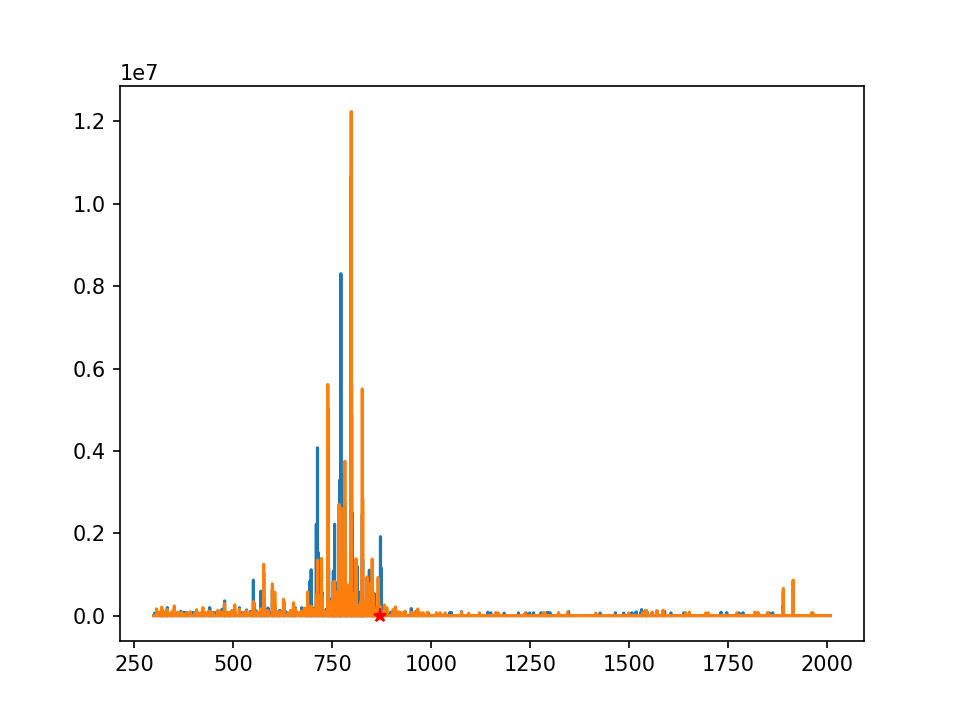

In [64]:
plt.figure()
plt.plot(lc_ex_sp[0], lc_ex_sp[1])
plt.plot(hc_ex_sp[0], hc_ex_sp[1])
plt.plot(test_sp.confs[0][0], [0], 'r*')
test_sp = test_sp*(np.interp(test_sp.confs[0][0], hc_ex_sp[0], hc_ex_sp[1])/test_sp.confs[0][1])
competing_sp = competing_sp*(np.interp(test_sp.confs[0][0], hc_ex_sp[0], hc_ex_sp[1])/competing_sp.confs[0][1])
test_sp.plot()
competing_sp.plot(color='red')

<IPython.core.display.Javascript object>


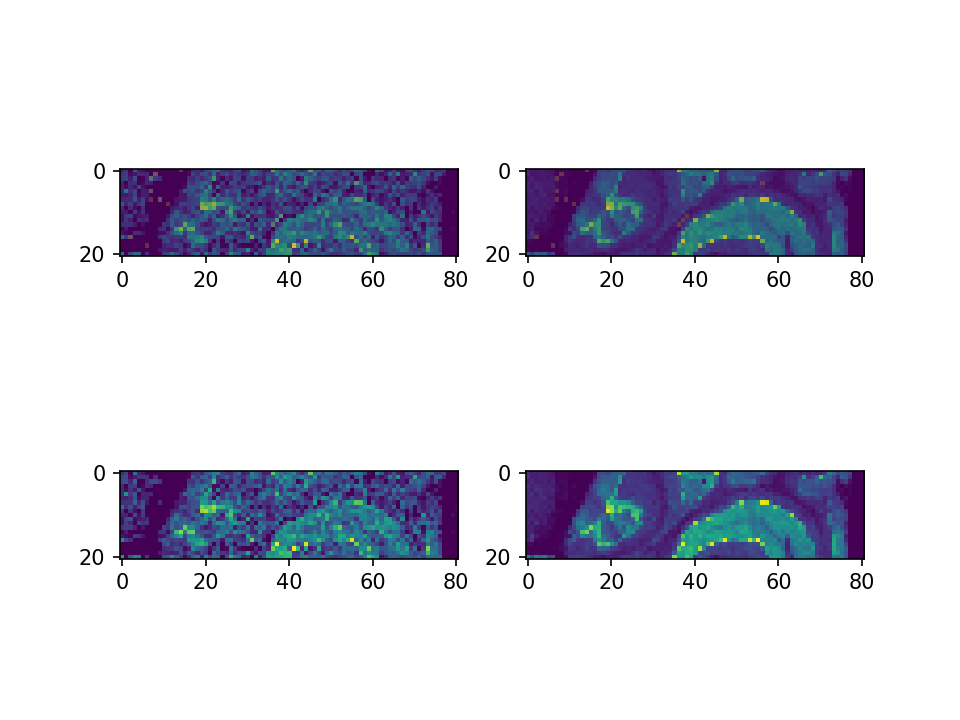

In [79]:
plt.figure()
plt.subplot(221)
plt.imshow(profile_ion_image(profile_images[test_image], 872.5357))
plt.imshow(masserstein_mask, alpha=0.2)
plt.subplot(222)
plt.imshow(profile_ion_image(profile_images[test_image], 872.5578))
plt.imshow(masserstein_mask, alpha=0.2)
plt.subplot(223)
plt.imshow(profile_ion_image(profile_images[test_image], 872.5357))
plt.subplot(224)
plt.imshow(profile_ion_image(profile_images[test_image], 872.5578))

<IPython.core.display.Javascript object>


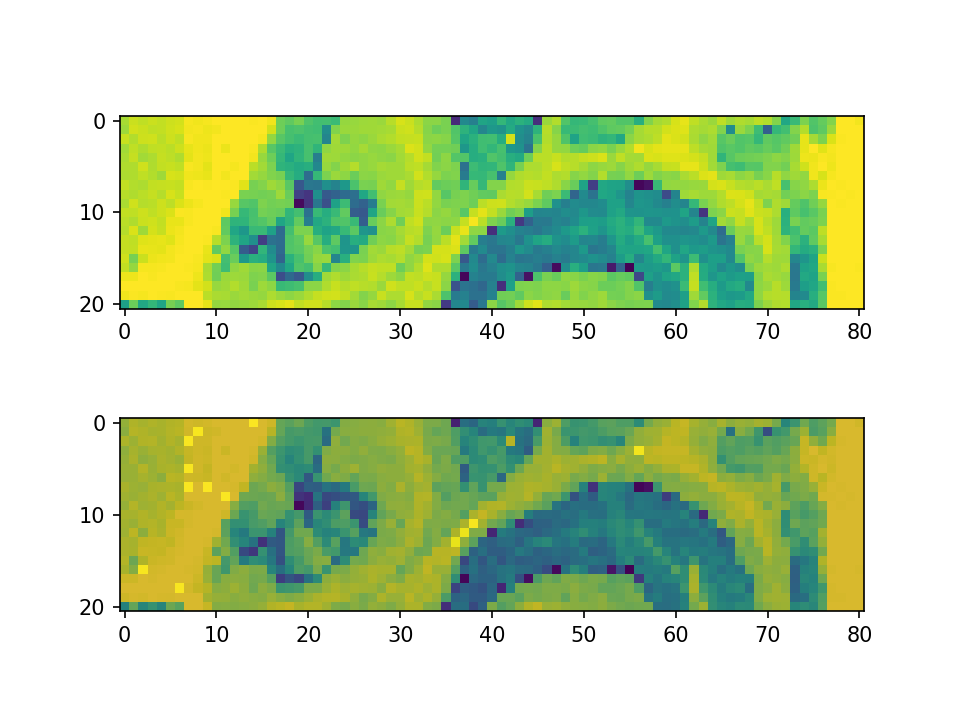

In [80]:
plt.figure()
plt.subplot(211)
plt.imshow(profile_ion_image(profile_images[test_image], 872.5357) - profile_ion_image(profile_images[test_image], 872.5578))
plt.subplot(212)
plt.imshow(profile_ion_image(profile_images[test_image], 872.5357) - profile_ion_image(profile_images[test_image], 872.5578))
plt.imshow(masserstein_mask, alpha=0.2)

Seems like a false positive. 
Therefore, in subsequent analyses we'll focus on lipids found in at least 400 pixels.  

In [52]:
print('Number of highly correlated lipids, rho>=0.8:')
for n in image_names:
    print(n, np.sum(signal_correlations[n][is_in_enough_pixels[n]] >= 0.8))
    
print('Number of moderately correlated lipids, 0.6<=rho<0.8:')
for n in image_names:
    print(n, np.sum((signal_correlations[n][is_in_enough_pixels[n]] >= 0.6)*(signal_correlations[n][is_in_enough_pixels[n]] < 0.8)))

print('Number of highly distorted lipids, rho<0.6:')
for n in image_names:
    print(n, np.sum(signal_correlations[n][is_in_enough_pixels[n]] < 0.6))


Number of highly correlated lipids, rho>=0.8:
cerebellum 63
bladder 33
Number of moderately correlated lipids, 0.6<=rho<0.8:
cerebellum 5
bladder 12
Number of highly distorted lipids, rho<0.6:
cerebellum 6
bladder 7


In [96]:
correlations_to_check = {n: sorted([(c,i) for c, i, t in zip(signal_correlations[n], 
                                                     range(len(signal_correlations[n])), 
                                                     is_in_enough_pixels[n]) if t]) for n in image_names}

Showing three lowest-correlation lipids after discarding micro-biomarkers:

<IPython.core.display.Javascript object>


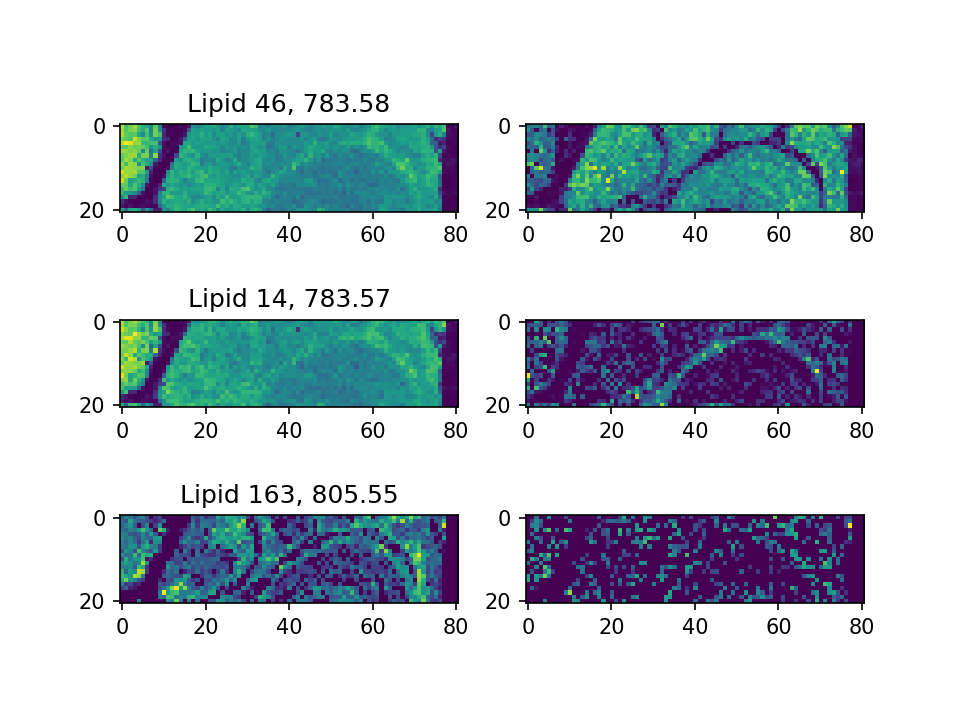

In [97]:
plt.figure()
for i, (c, lid) in enumerate(correlations_to_check['cerebellum'][:3]):
    plt.subplot(321+2*i)
    plt.title('Lipid %i, %.2f' % (lid, lipid_spectra['cerebellum'][lid].confs[0][0]))
    plt.imshow(single_peak_intensities['cerebellum'][...,lid])
    plt.subplot(322+2*i)
    plt.imshow(masserstein_estimation['cerebellum'][...,lid])

<IPython.core.display.Javascript object>


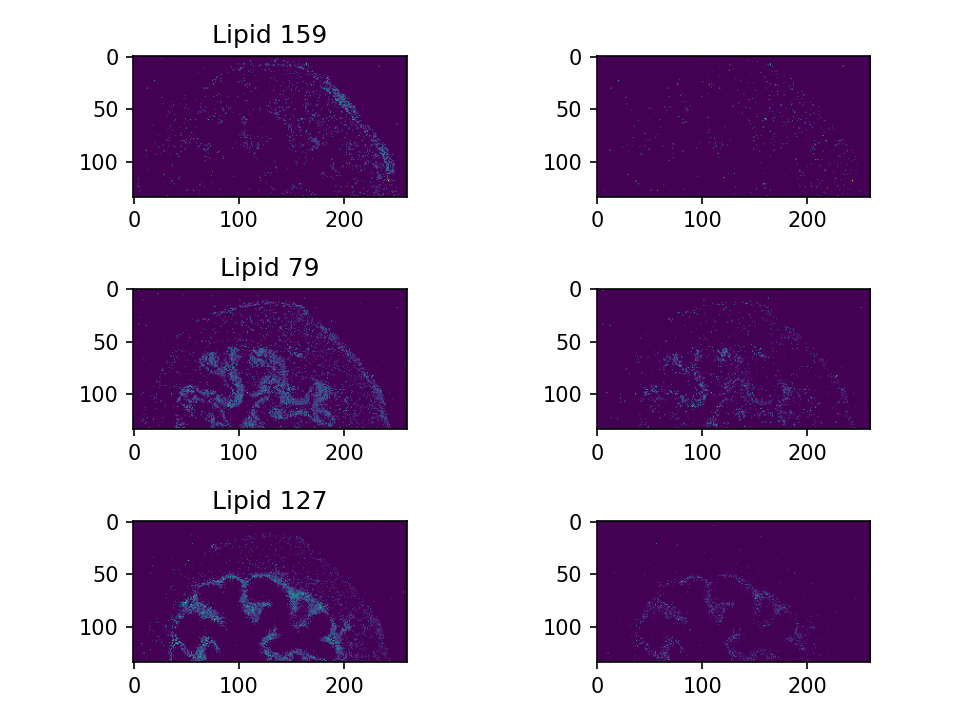

In [84]:
plt.figure()
for i, (c, lid) in enumerate(correlations_to_check['bladder'][6:9]):
    plt.subplot(321+2*i)
    plt.title('Lipid %i' % lid)
    plt.imshow(single_peak_intensities['bladder'][...,lid])
    plt.subplot(322+2*i)
    plt.imshow(masserstein_estimation['bladder'][...,lid])
plt.tight_layout()

Analyze lipids 14 and 46 from the cerebellum as a good example

In [101]:
lipid14_enrichment = masserstein_estimation['cerebellum'][...,14] > 0.008
lipid46_enrichment = masserstein_estimation['cerebellum'][...,46] > 0.008

<IPython.core.display.Javascript object>


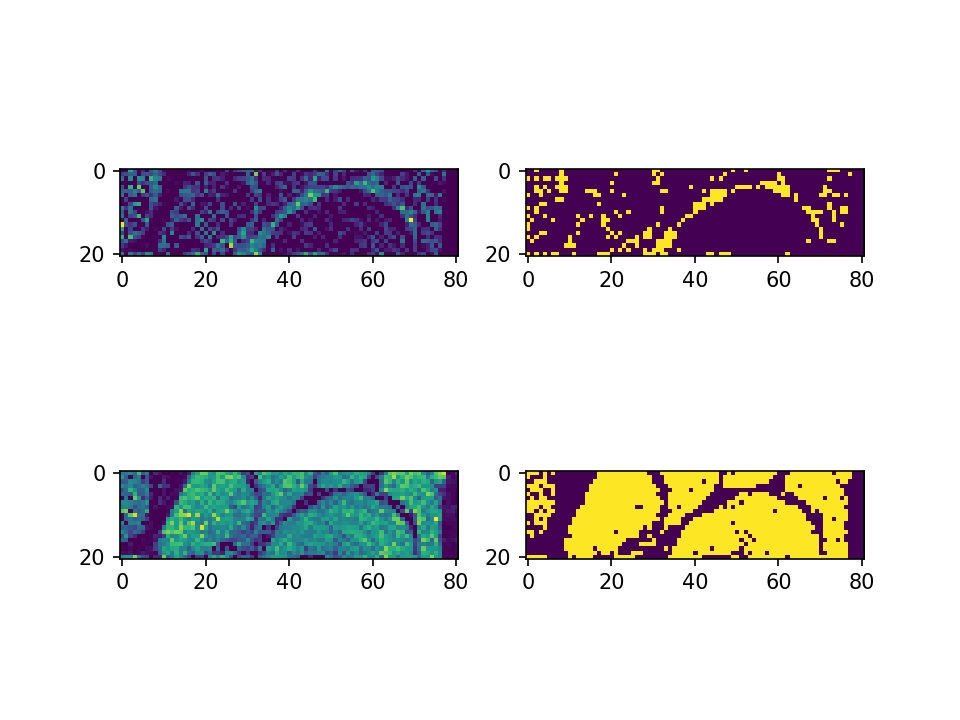

In [102]:
plt.figure()
plt.subplot(221)
plt.imshow(masserstein_estimation['cerebellum'][...,14])
plt.subplot(222)
plt.imshow(lipid14_enrichment)
plt.subplot(223)
plt.imshow(masserstein_estimation['cerebellum'][...,46])
plt.subplot(224)
plt.imshow(lipid46_enrichment)


In [115]:
test_mz = np.linspace(782, 787, num=5001)
cerebellum_avs = segment_average_spectra(profile_images['cerebellum'], 
                                         np.ones(image_shapes['cerebellum']), 
                                         test_mz)[0]
lipid14_lo, lipid14_hi = segment_average_spectra(profile_images['cerebellum'], 
                                      lipid14_enrichment, 
                                      test_mz)
lipid46_lo,lipid46_hi  = segment_average_spectra(profile_images['cerebellum'], 
                                      lipid46_enrichment, 
                                      test_mz)


<IPython.core.display.Javascript object>


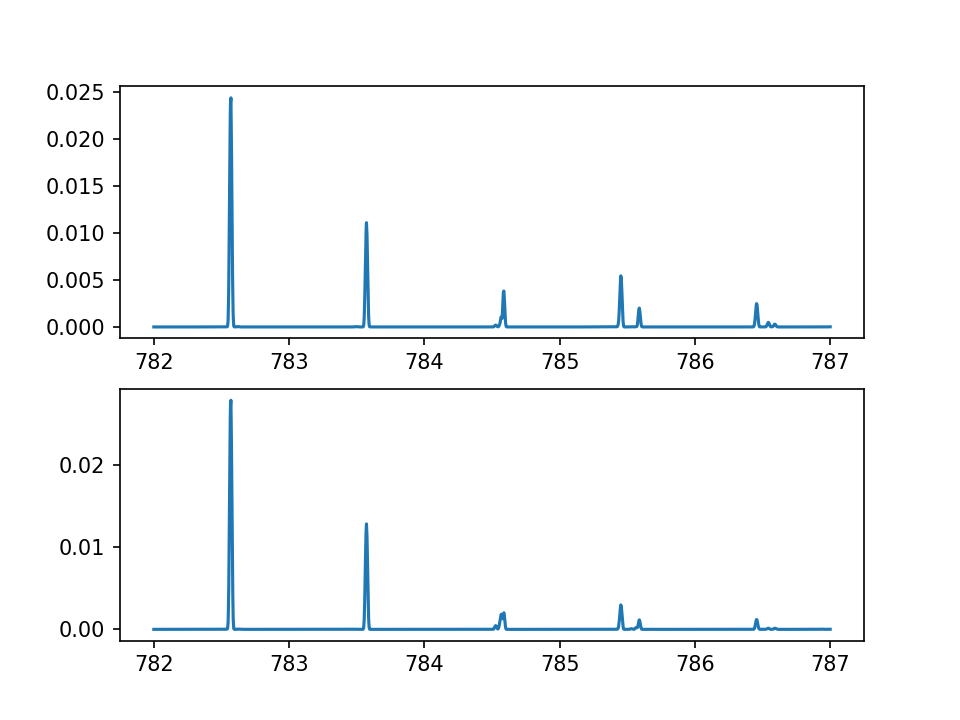

In [118]:
plt.figure()
plt.subplot(211)
plt.plot(test_mz, lipid46_hi/np.sum(lipid46_hi))
plt.subplot(212)
plt.plot(test_mz, lipid14_hi/np.sum(lipid14_hi))

<IPython.core.display.Javascript object>


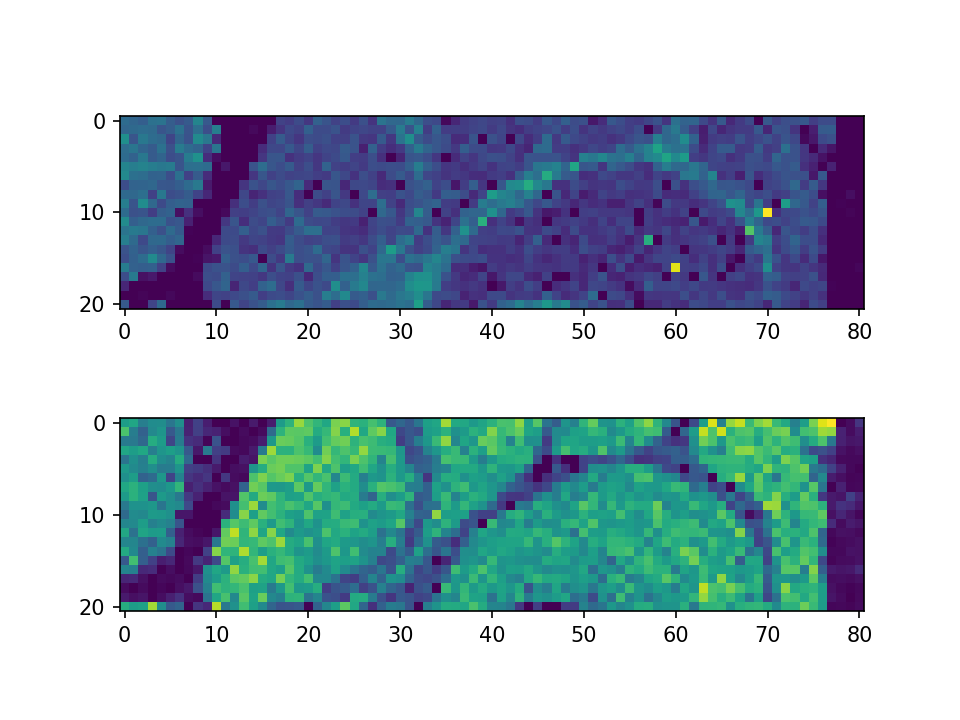

In [117]:
plt.figure()
plt.subplot(211)
plt.imshow(profile_ion_image(profile_images[test_image], 784.5651))
plt.subplot(212)
plt.imshow(profile_ion_image(profile_images[test_image], 784.5903))


Interference:

<IPython.core.display.Javascript object>


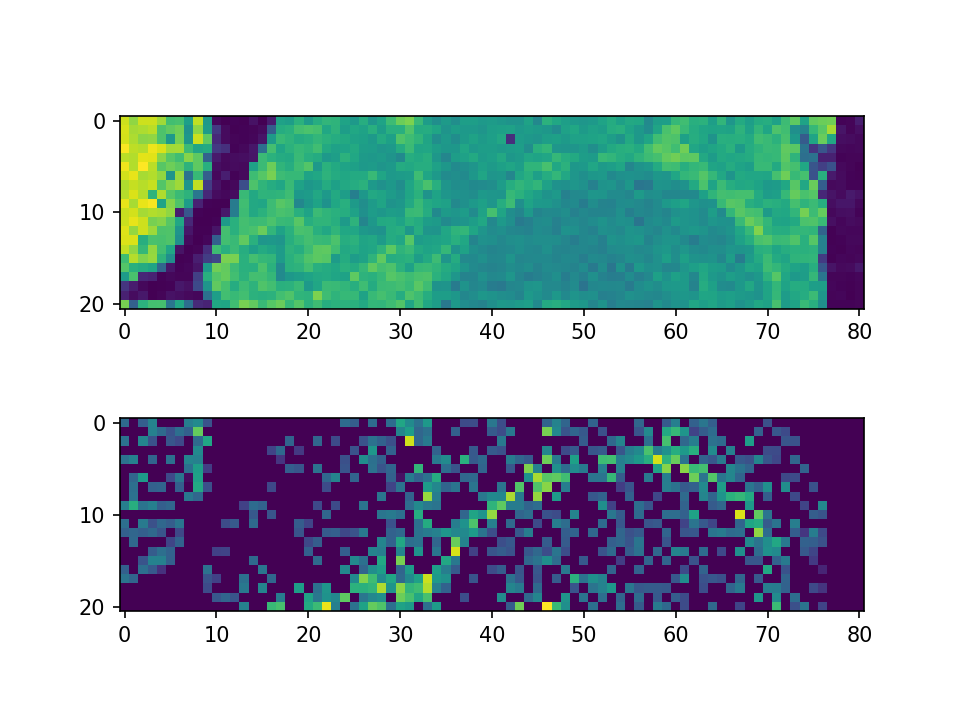

In [121]:
plt.figure()
plt.subplot(211)
plt.imshow(profile_ion_image(profile_images[test_image], 782.5672))
plt.subplot(212)
plt.imshow(profile_ion_image(profile_images[test_image], 784.5266))


Remnant:

<IPython.core.display.Javascript object>


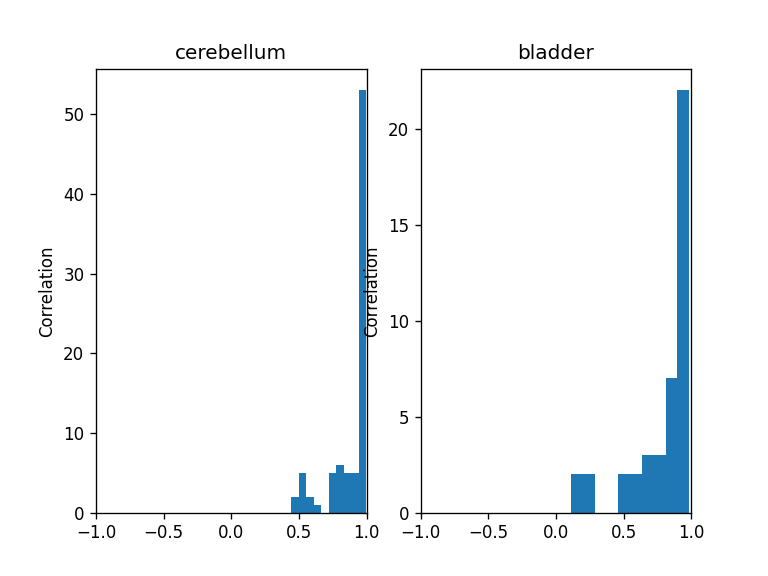

In [17]:
# plt.figure()
# plt.subplot(121)
# plt.title(image_names[0])
# plt.hist(signal_correlations[image_names[0]])
# plt.ylabel('Correlation')
# plt.xlim(-1, 1)
# plt.subplot(122)
# plt.title(image_names[1])
# plt.hist(signal_correlations[image_names[1]])
# plt.ylabel('Correlation')
# plt.xlim(-1, 1)
# plt.show() 

We had a bunch of lipids around 0.5 in cerebellum